In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils.aperture import CircularAnnulus, CircularAperture, aperture_photometry, ApertureStats
from astropy.stats import SigmaClip


import glob
from photutils.aperture import aperture_photometry, CircularAperture


files_ch1 = sorted(glob.glob("6_2/*ch1*s3d.fits"))
files_ch2 = sorted(glob.glob("6_2/*ch2*s3d.fits"))
files_ch3 = sorted(glob.glob("6_2/*ch3*s3d.fits"))
files_ch4 = sorted(glob.glob("6_2/*ch4*s3d.fits"))


## Getting barycentric-corrected times:

In [1]:
from jwst import datamodels

time_jwst = []
for i in range(1,6):
    data = datamodels.CubeModel('jw04572009001_02101_00001-seg00{}_mirifulong_calints.fits'.format(i))
    print(i)
    time_jwst.extend(data.int_times['int_mid_BJD_TDB']-60408)

/home/tamojeet/.local/lib/python3.8/site-packages/asdf/yamlutil.py:304: AsdfConversionWarning: tag:stsci.edu:gwcs/wcs-1.2.0 is not recognized, converting to raw Python data structure
  warnings.warn(


1


/home/tamojeet/.local/lib/python3.8/site-packages/asdf/yamlutil.py:304: AsdfConversionWarning: tag:stsci.edu:gwcs/wcs-1.2.0 is not recognized, converting to raw Python data structure
  warnings.warn(


2


/home/tamojeet/.local/lib/python3.8/site-packages/asdf/yamlutil.py:304: AsdfConversionWarning: tag:stsci.edu:gwcs/wcs-1.2.0 is not recognized, converting to raw Python data structure
  warnings.warn(


3


/home/tamojeet/.local/lib/python3.8/site-packages/asdf/yamlutil.py:304: AsdfConversionWarning: tag:stsci.edu:gwcs/wcs-1.2.0 is not recognized, converting to raw Python data structure
  warnings.warn(


4


/home/tamojeet/.local/lib/python3.8/site-packages/asdf/yamlutil.py:304: AsdfConversionWarning: tag:stsci.edu:gwcs/wcs-1.2.0 is not recognized, converting to raw Python data structure
  warnings.warn(


5


In [3]:
np.save('TIMES_BARCORR_6APR_EXP2.npy', time_jwst)

## Channel 1:

In [7]:
files_ch1 = sorted(glob.glob("6_2/*ch1*s3d.fits"))
files = files_ch1

colors_channel = ['#FEB24C','#FD8D3C','#F03B20','#BD0026']
color = colors_channel[0]
sgra_pixel = np.array([17,18])
frac = 0.1
t1, t2 = 6, 7

# Modified code :-

med_im = np.nanmean(fits.open(files[25])[1].data, axis=0)
ref_pixels = np.where(np.abs(med_im - med_im[sgra_pixel[0],sgra_pixel[1]]) <= frac*med_im[sgra_pixel[0],sgra_pixel[1]])
far = []
for j in range(len(ref_pixels[0])):
    if (ref_pixels[0][j] - sgra_pixel[0])**2 + (ref_pixels[1][j] - sgra_pixel[1])**2 <= 3**2:
        pass
    else:
        far.append(j)
far = np.array(far)
ref_pixels = np.array(ref_pixels)
ref_pixels = ref_pixels[:,far]

print(len(ref_pixels[0]))
sgra_lc = np.zeros(85)
ref_lc = np.zeros((len(ref_pixels[0]) , 85))
times = np.load('TIMES_BARCORR_FROM_DATAMODEL.npy')

for i in range(85):
    ff = fits.open(files[i])
    arr = ff[1].data
    arr[-10:] = arr[:10] = arr[740:770] = arr[530:560] = np.nan
    data = np.nanmean(arr, axis = 0)
    h = ff[0].header
    if h["DATE-OBS"] == '2024-04-06':
        t = h['EXPSTART']-60400 + (h['INTSTART']+h['INTEND'])/2*h['EFFINTTM']/86400
        times[i] = t
        sgra_lc[i] = data[sgra_pixel[0],sgra_pixel[1]]
        ref_lc[:,i] = np.array([data[ref_pixels[0][i], ref_pixels[1][i]] for i in range(len(ref_pixels[0]))])
    else:
        break

#sgra_lc -= np.nanmedian(sgra_lc)
#[ref_lc[j,:] -= np.nanmedian(ref_lc[j,:]) for j in range(85)]

/tmp/ipykernel_471/1730640005.py:12: RuntimeWarning: Mean of empty slice
  med_im = np.nanmean(fits.open(files[25])[1].data, axis=0)
/tmp/ipykernel_471/1730640005.py:33: RuntimeWarning: Mean of empty slice
  data = np.nanmean(arr, axis = 0)


107


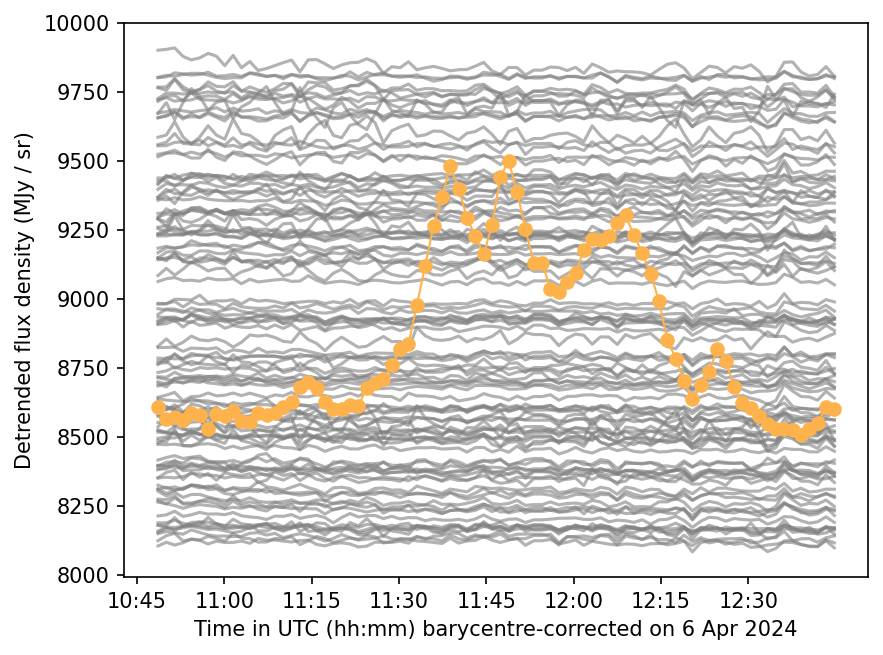

In [8]:
sgra_lc = sgra_lc[np.argsort(times)]
#sgra_lc -= np.nanmedian(sgra_lc[:30])
ref_lc = ref_lc.copy()
for j in range(len(ref_pixels[0])):
    #ref_lc[j,:] = ref_lc[j,:] - np.nanmedian(ref_lc[j,:]) 
    ref_lc[j,:] = ref_lc[j,:][np.argsort(times)] 

sgra_ch1 = sgra_lc.copy()
ref_ch1 = ref_lc.copy()

sgra_lc -= np.nanmedian(sgra_lc[:30])
for j in range(len(ref_pixels[0])):
    ref_lc[j,:] = ref_lc[j,:] - np.nanmedian(ref_lc[j,:]) 
        

times = np.load('TIMES_BARCORR_FROM_DATAMODEL.npy')

trend_coeffs = np.nanmean([np.polyfit(times, r, deg=1) for r in ref_lc], axis=0)
trend = np.poly1d(trend_coeffs)(times)

trend_1 = trend.copy()

times0 = (times)*24

plt.figure(dpi=150)
[plt.plot(times0[3:], ref_ch1[j][3:], color='grey',alpha=0.6) for j in range(len(ref_pixels[0]))]
plt.plot(times0[3:], sgra_ch1[3:], color=color,lw=1,marker='o')
#plt.plot(times0, trend, color='red',lw=2)
plt.xticks(np.arange(10.75, 12.75, 0.25), labels=['10:45','11:00','11:15','11:30','11:45','12:00','12:15','12:30'])
#plt.axhline([0])
#plt.ylim(-150,None)
plt.xlabel('Time in UTC (hh:mm) barycentre-corrected on 6 Apr 2024')
plt.ylabel('Detrended flux density (MJy / sr)')
#plt.savefig('lc-ch4.pdf')
plt.show()

## Channel 2:

In [9]:
files = files_ch2

colors_channel = ['#FEB24C','#FD8D3C','#F03B20','#BD0026']
color = colors_channel[1]
sgra_pixel = np.array([17,18])
frac = 0.1
t1, t2 = 6, 7

# Modified code :-

med_im = np.nanmean(fits.open(files[25])[1].data, axis=0)

ref_pixels = np.where(np.abs(med_im - med_im[sgra_pixel[0],sgra_pixel[1]]) <= frac*med_im[sgra_pixel[0],sgra_pixel[1]])

far = []
for j in range(len(ref_pixels[0])):
    if (ref_pixels[0][j] - sgra_pixel[0])**2 + (ref_pixels[1][j] - sgra_pixel[1])**2 <= 3**2:
        pass
    else:
        far.append(j)
far = np.array(far)
ref_pixels = np.array(ref_pixels)
ref_pixels = ref_pixels[:,far]

print(len(ref_pixels[0]))
sgra_lc = np.zeros(85)
ref_lc = np.zeros((len(ref_pixels[0]) , 85))
times = np.zeros(85)

for i in range(85):
    ff = fits.open(files[i])
    arr = ff[1].data
    arr[:10] = arr[-10:] = arr[380:400] = np.nan
    data = np.nanmean(arr, axis = 0)
    h = ff[0].header
    if h["DATE-OBS"] == '2024-04-06':
        t = h['EXPSTART']-60400 + (h['INTSTART']+h['INTEND'])/2*h['EFFINTTM']/86400
        times[i] = t
        sgra_lc[i] = data[sgra_pixel[0],sgra_pixel[1]]
        ref_lc[:,i] = np.array([data[ref_pixels[0][i], ref_pixels[1][i]] for i in range(len(ref_pixels[0]))])
    else:
        break

#sgra_lc -= np.nanmedian(sgra_lc)
#[ref_lc[j,:] -= np.nanmedian(ref_lc[j,:]) for j in range(85)]

/tmp/ipykernel_471/2379174556.py:11: RuntimeWarning: Mean of empty slice
  med_im = np.nanmean(fits.open(files[25])[1].data, axis=0)
/tmp/ipykernel_471/2379174556.py:34: RuntimeWarning: Mean of empty slice
  data = np.nanmean(arr, axis = 0)


57


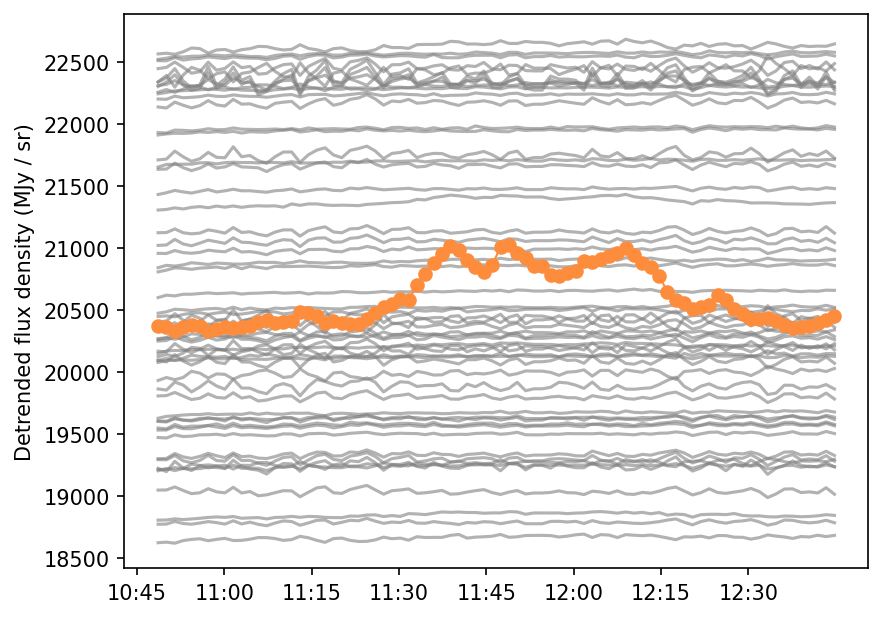

In [10]:
sgra_lc = sgra_lc[np.argsort(times)]
#sgra_lc -= np.nanmedian(sgra_lc[:30])
ref_lc = ref_lc.copy()
for j in range(len(ref_pixels[0])):
    #ref_lc[j,:] = ref_lc[j,:] - np.nanmedian(ref_lc[j,:]) 
    ref_lc[j,:] = ref_lc[j,:][np.argsort(times)] 

sgra_ch2 = sgra_lc.copy()
ref_ch2 = ref_lc.copy()

sgra_lc -= np.nanmedian(sgra_lc[:30])
for j in range(len(ref_pixels[0])):
    ref_lc[j,:] = ref_lc[j,:] - np.nanmedian(ref_lc[j,:])     
    
    
times = np.load('TIMES_BARCORR_FROM_DATAMODEL.npy')

trend_coeffs = np.nanmean([np.polyfit(times, r, deg=1) for r in ref_lc], axis=0)
trend = np.poly1d(trend_coeffs)(times)

trend_2 = trend.copy()

times0 = (times)*24

plt.figure(dpi=150)
[plt.plot(times0[3:], ref_ch2[j][3:], color='grey',alpha=0.6) for j in range(len(ref_pixels[0]))]
plt.plot(times0[3:], sgra_ch2[3:], color=color,lw=1,marker='o')
#plt.plot(times0, trend, color='red',lw=2)
plt.xticks(np.arange(10.75, 12.75, 0.25), labels=['10:45','11:00','11:15','11:30','11:45','12:00','12:15','12:30'])
#plt.axhline([0])
#plt.ylim(-150,None)
#plt.xlabel('Time in UTC (hh:mm) barycentre-corrected on 6 Apr 2024')
plt.ylabel('Detrended flux density (MJy / sr)')
#plt.savefig('lc-ch4.pdf')
plt.show()

In [50]:
second = sgra_ch2.copy()


## Channel 3:

In [11]:
files = files_ch3

colors_channel = ['#FEB24C','#FD8D3C','#F03B20','#BD0026']
color = colors_channel[2]
sgra_pixel = np.array([21,18])
frac = 0.1
t1, t2 = 6, 7

# Modified code :-

med_im = np.nanmean(fits.open(files[25])[1].data, axis=0)
ref_pixels = np.where(np.abs(med_im - med_im[sgra_pixel[0],sgra_pixel[1]]) <= frac*med_im[sgra_pixel[0],sgra_pixel[1]])
far = []
for j in range(len(ref_pixels[0])):
    if (ref_pixels[0][j] - sgra_pixel[0])**2 + (ref_pixels[1][j] - sgra_pixel[1])**2 <= 3**2:
        pass
    else:
        far.append(j)
far = np.array(far)
ref_pixels = np.array(ref_pixels)
ref_pixels = ref_pixels[:,far]

print(len(ref_pixels[0]))
sgra_lc = np.zeros(85)
ref_lc = np.zeros((len(ref_pixels[0]) , 85))
times = np.zeros(85)

for i in range(85):
    ff = fits.open(files[i])
    arr = ff[1].data
    arr[:20] = arr[-20:] = arr[480:520] = np.nan
    data = np.nanmean(arr, axis = 0)
    h = ff[0].header
    if h["DATE-OBS"] == '2024-04-06':
        t = h['EXPSTART']-60400 + (h['INTSTART']+h['INTEND'])/2*h['EFFINTTM']/86400
        times[i] = t
        sgra_lc[i] = data[sgra_pixel[0],sgra_pixel[1]]
        ref_lc[:,i] = np.array([data[ref_pixels[0][i], ref_pixels[1][i]] for i in range(len(ref_pixels[0]))])
    else:
        break

#sgra_lc -= np.nanmedian(sgra_lc)
#[ref_lc[j,:] -= np.nanmedian(ref_lc[j,:]) for j in range(85)]

/tmp/ipykernel_471/1415422246.py:11: RuntimeWarning: Mean of empty slice
  med_im = np.nanmean(fits.open(files[25])[1].data, axis=0)
/tmp/ipykernel_471/1415422246.py:32: RuntimeWarning: Mean of empty slice
  data = np.nanmean(arr, axis = 0)


39


/home/tamojeet/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


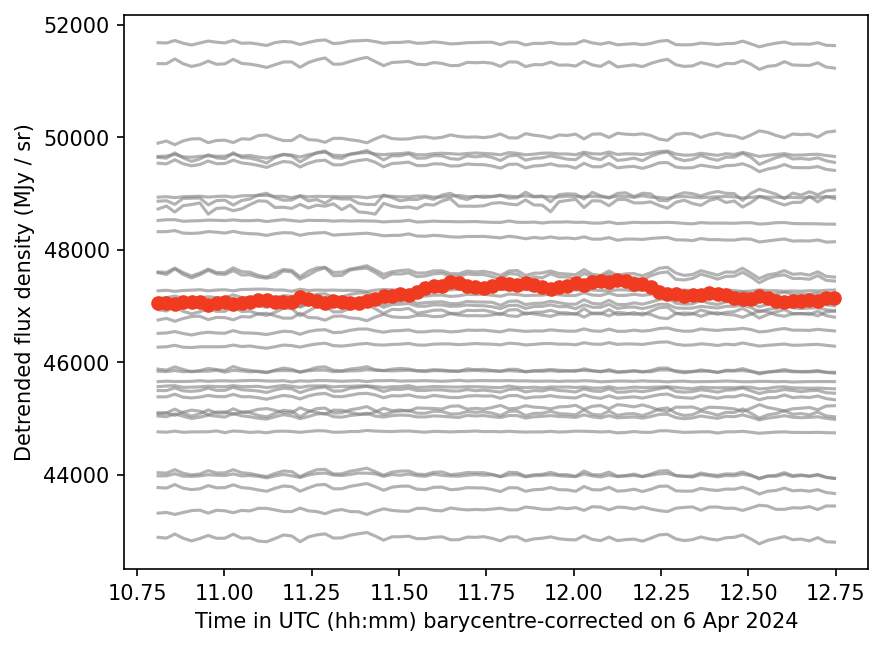

-0.837694735430925

In [12]:
sgra_lc = sgra_lc[np.argsort(times)]
#sgra_lc -= np.nanmedian(sgra_lc[:30])
ref_lc = ref_lc.copy()
for j in range(len(ref_pixels[0])):
    #ref_lc[j,:] = ref_lc[j,:] - np.nanmedian(ref_lc[j,:]) 
    ref_lc[j,:] = ref_lc[j,:][np.argsort(times)] 

color = colors_channel[2]   
sgra_ch3 = sgra_lc.copy()
ref_ch3 = ref_lc.copy()

sgra_lc -= np.nanmedian(sgra_lc[:30])
for j in range(len(ref_pixels[0])):
    ref_lc[j,:] = ref_lc[j,:] - np.nanmedian(ref_lc[j,:]) 
        
times = np.load('TIMES_BARCORR_FROM_DATAMODEL.npy')

trend_coeffs = np.nanmean([np.polyfit(times[1:], r[1:], deg=1) for r in ref_lc], axis=0)
trend = np.poly1d(trend_coeffs)(times)

trend_3 = trend.copy()

times0 = (times)*24


plt.figure(dpi=150)
[plt.plot(times0[3:], ref_ch3[j][3:], color='grey',alpha=0.6) for j in range(len(ref_pixels[0]))]
plt.plot(times0[3:], sgra_ch3[3:], color=color,lw=1,marker='o')
#plt.plot(times0, trend, color='red',lw=2)
#plt.xticks(np.arange(10.75, 12.75, 0.25), labels=['10:45','11:00','11:15','11:30','11:45','12:00','12:15','12:30'])
#plt.axhline([0])
#plt.ylim(-150,None)
plt.xlabel('Time in UTC (hh:mm) barycentre-corrected on 6 Apr 2024')
plt.ylabel('Detrended flux density (MJy / sr)')
#plt.savefig('lc-ch4.pdf')
plt.show()
(trend_3[40] - trend_3[10]) / (times0[40] - times0[10])

## Channel 4:

In [13]:
files = files_ch4

colors_channel = ['#FEB24C','#FD8D3C','#F03B20','#BD0026']
color = colors_channel[3]
sgra_pixel = np.array([13,15])
frac = 0.15
t1, t2 = 6, 7

# Modified code :-

med_im = np.nanmean(fits.open(files[25])[1].data, axis=0)
ref_pixels = np.where(np.abs(med_im - med_im[sgra_pixel[0],sgra_pixel[1]]) <= frac*med_im[sgra_pixel[0],sgra_pixel[1]])
far = []
for j in range(len(ref_pixels[0])):
    if (ref_pixels[0][j] - sgra_pixel[0])**2 + (ref_pixels[1][j] - sgra_pixel[1])**2 <= 3**2:
        pass
    else:
        far.append(j)
far = np.array(far)
ref_pixels = np.array(ref_pixels)
ref_pixels = ref_pixels[:,far]

print(len(ref_pixels[0]))
sgra_lc = np.zeros(85)
ref_lc = np.zeros((len(ref_pixels[0]) , 85))
times = np.zeros(85)

for i in range(85):
    ff = fits.open(files[i])
    arr = ff[1].data
    arr[150:180] = np.nan
    data = np.nanmean(arr, axis = 0)
    h = ff[0].header
    if h["DATE-OBS"] == '2024-04-06':
        t = h['EXPSTART']-60400 + (h['INTSTART']+h['INTEND'])/2*h['EFFINTTM']/86400
        times[i] = t
        sgra_lc[i] = data[sgra_pixel[0],sgra_pixel[1]]
        ref_lc[:,i] = np.array([data[ref_pixels[0][i], ref_pixels[1][i]] for i in range(len(ref_pixels[0]))])
    else:
        break

#sgra_lc -= np.nanmedian(sgra_lc)
#[ref_lc[j,:] -= np.nanmedian(ref_lc[j,:]) for j in range(85)]

/tmp/ipykernel_471/2978619541.py:11: RuntimeWarning: Mean of empty slice
  med_im = np.nanmean(fits.open(files[25])[1].data, axis=0)
/tmp/ipykernel_471/2978619541.py:32: RuntimeWarning: Mean of empty slice
  data = np.nanmean(arr, axis = 0)


14


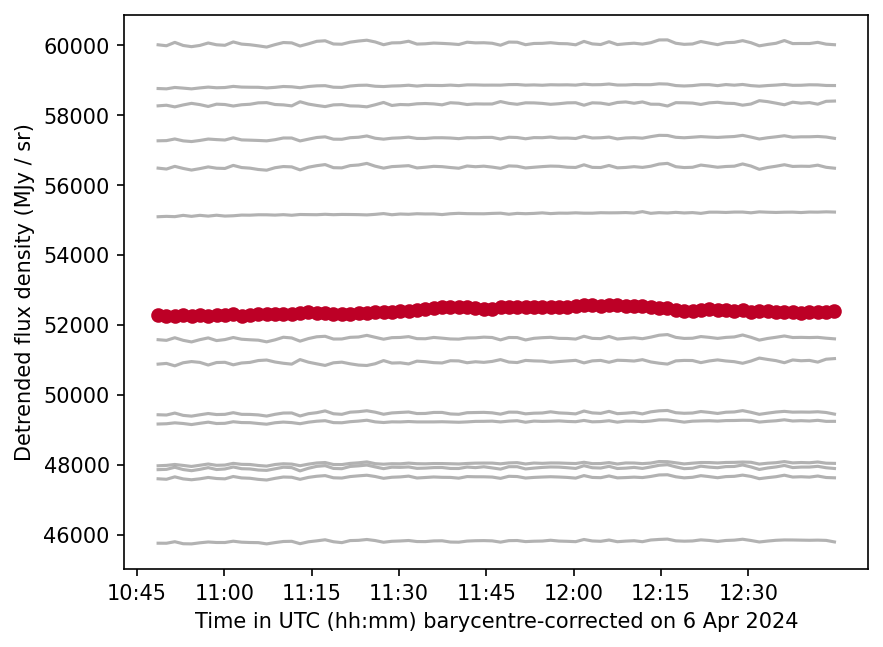

40.95789249980057

In [14]:
sgra_lc = sgra_lc[np.argsort(times)]
#sgra_lc -= np.nanmedian(sgra_lc[:30])
ref_lc = ref_lc.copy()
for j in range(len(ref_pixels[0])):
    #ref_lc[j,:] = ref_lc[j,:] - np.nanmedian(ref_lc[j,:]) 
    ref_lc[j,:] = ref_lc[j,:][np.argsort(times)] 

sgra_ch4 = sgra_lc.copy()
ref_ch4 = ref_lc.copy()

sgra_lc -= np.nanmedian(sgra_lc[:30])
for j in range(len(ref_pixels[0])):
    ref_lc[j,:] = ref_lc[j,:] - np.nanmedian(ref_lc[j,:]) 
    
    
times = np.load('TIMES_BARCORR_FROM_DATAMODEL.npy')

trend_coeffs = np.nanmean([np.polyfit(times[1:], r[1:], deg=1) for r in ref_lc], axis=0)
trend = np.poly1d(trend_coeffs)(times)

trend_4 = trend.copy()

times0 = (times)*24

plt.figure(dpi=150)
[plt.plot(times0[3:], ref_ch4[j][3:], color='grey',alpha=0.6) for j in range(len(ref_pixels[0]))]
plt.plot(times0[3:], sgra_ch4[3:], color=color,lw=1,marker='o')
#plt.plot(times0, trend, color='red',lw=2)
plt.xticks(np.arange(10.75, 12.75, 0.25), labels=['10:45','11:00','11:15','11:30','11:45','12:00','12:15','12:30'])
#plt.axhline([0])
#plt.ylim(-150,None)
plt.xlabel('Time in UTC (hh:mm) barycentre-corrected on 6 Apr 2024')
plt.ylabel('Detrended flux density (MJy / sr)')
#plt.savefig('lc-ch4.pdf')
plt.show()
(trend_4[40] - trend_4[10]) / (times0[40] - times0[10])

## Plotting - 

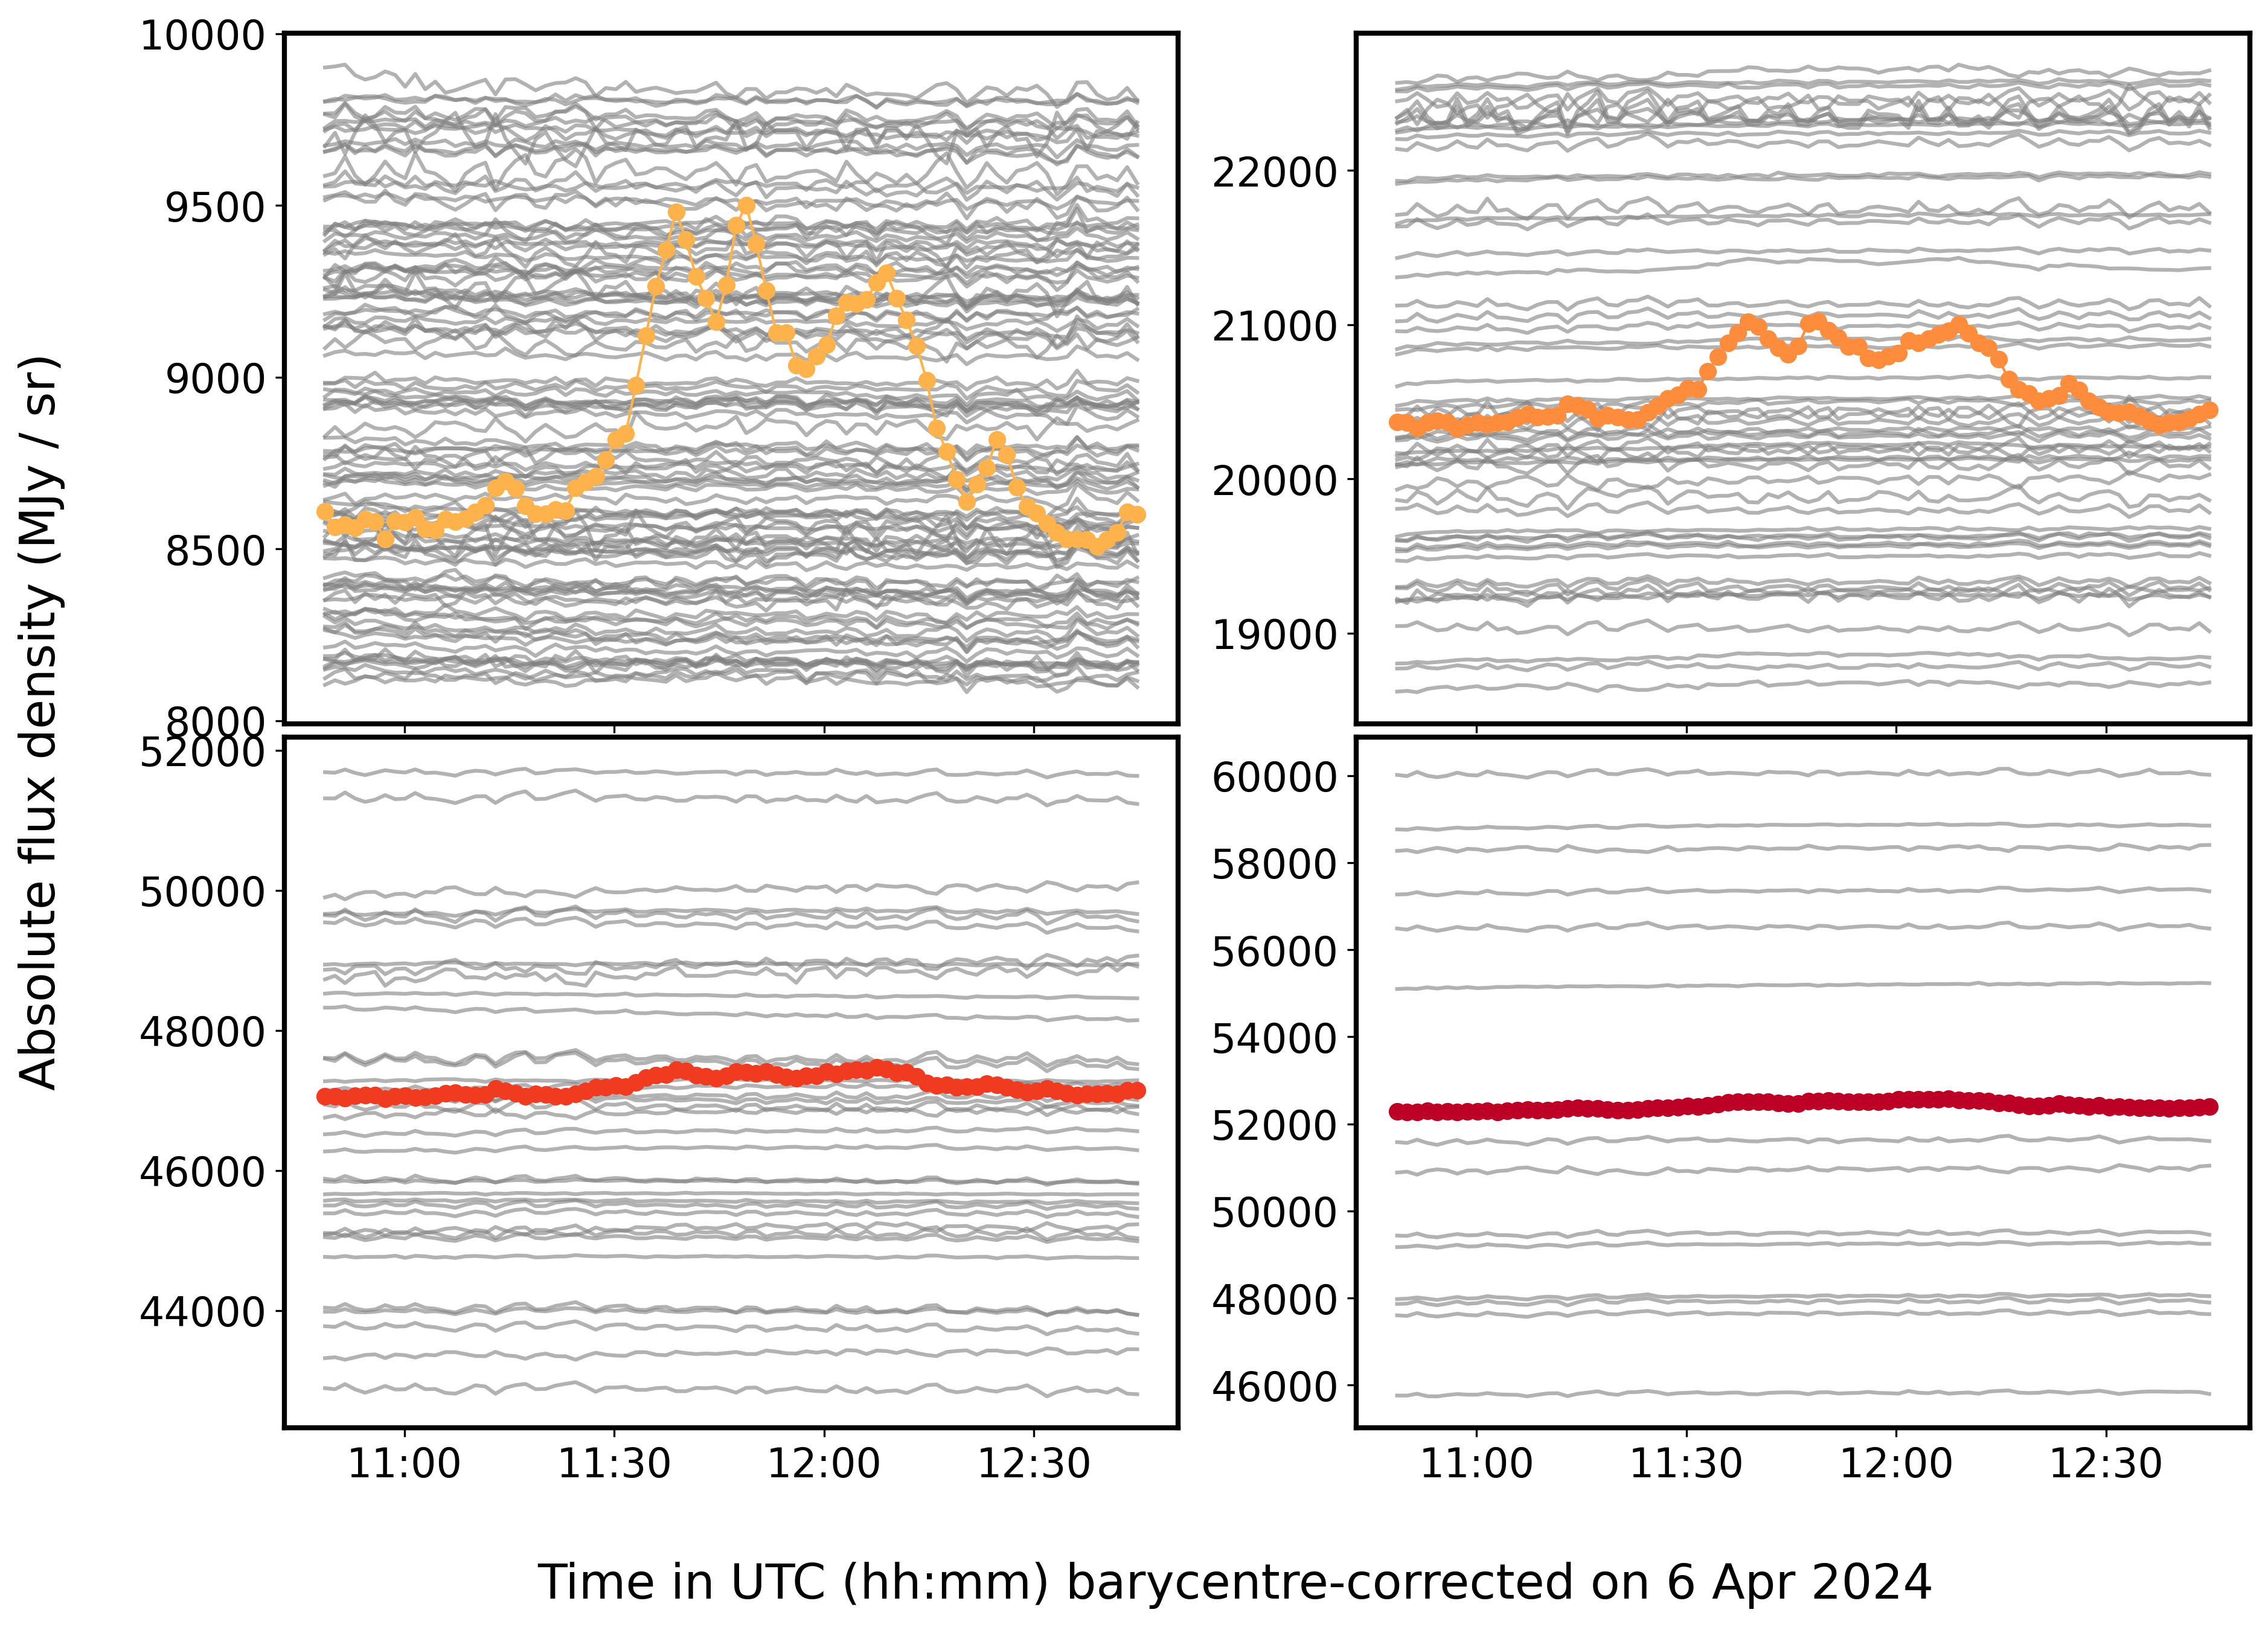

In [17]:
fig, ax = plt.subplots(2,2,figsize=(14,10), dpi=300,sharex=True, gridspec_kw={"hspace":0.02, "wspace":0.2})
#fig.add_subplot(111, frameon=False)

times0 = (np.load('times_barcorr/LC_CH1_APR6_TIMES_BARCORR.npy')-6)*24

plt.rc('font', size=16)
#plt.rc('labels', size=16)

spine_thickness = 2
for spine in ax[0,0].spines.values():
    spine.set_linewidth(spine_thickness)
for spine in ax[0,1].spines.values():
    spine.set_linewidth(spine_thickness)
for spine in ax[1,0].spines.values():
    spine.set_linewidth(spine_thickness)
for spine in ax[1,1].spines.values():
    spine.set_linewidth(spine_thickness)


[ax[0,0].plot(times0[3:], ref_ch1[j][3:], color='grey',alpha=0.6) for j in range(ref_ch1.shape[0])]
ax[0,0].plot(times0[3:], sgra_ch1[3:], color=colors_channel[0],lw=1,marker='o')

[ax[0,1].plot(times0[3:], ref_ch2[j][3:], color='grey',alpha=0.6) for j in range(ref_ch2.shape[0])]
ax[0,1].plot(times0[3:], sgra_ch2[3:], color=colors_channel[1],lw=1,marker='o')

[ax[1,0].plot(times0[3:], ref_ch3[j][3:], color='grey',alpha=0.6) for j in range(ref_ch3.shape[0])]
ax[1,0].plot(times0[3:], sgra_ch3[3:], color=colors_channel[2],lw=1,marker='o')

[ax[1,1].plot(times0[3:], ref_ch4[j][3:], color='grey',alpha=0.6) for j in range(ref_ch4.shape[0])]
ax[1,1].plot(times0[3:], sgra_ch4[3:], color=colors_channel[3],lw=1,marker='o')

ax[1,0].set_xticks(np.arange(11, 12.76, 0.5), labels=['11:00','11:30','12:00','12:30'])
ax[1,1].set_xticks(np.arange(11, 12.76, 0.5), labels=['11:00','11:30','12:00','12:30'])

fig.supxlabel('Time in UTC (hh:mm) barycentre-corrected on 6 Apr 2024')
fig.supylabel('Absolute flux density (MJy / sr)')
#fig.suptitle('No Median subtraction, No Linear Trend correction')
plt.savefig('abs-lc.pdf')

/home/tamojeet/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


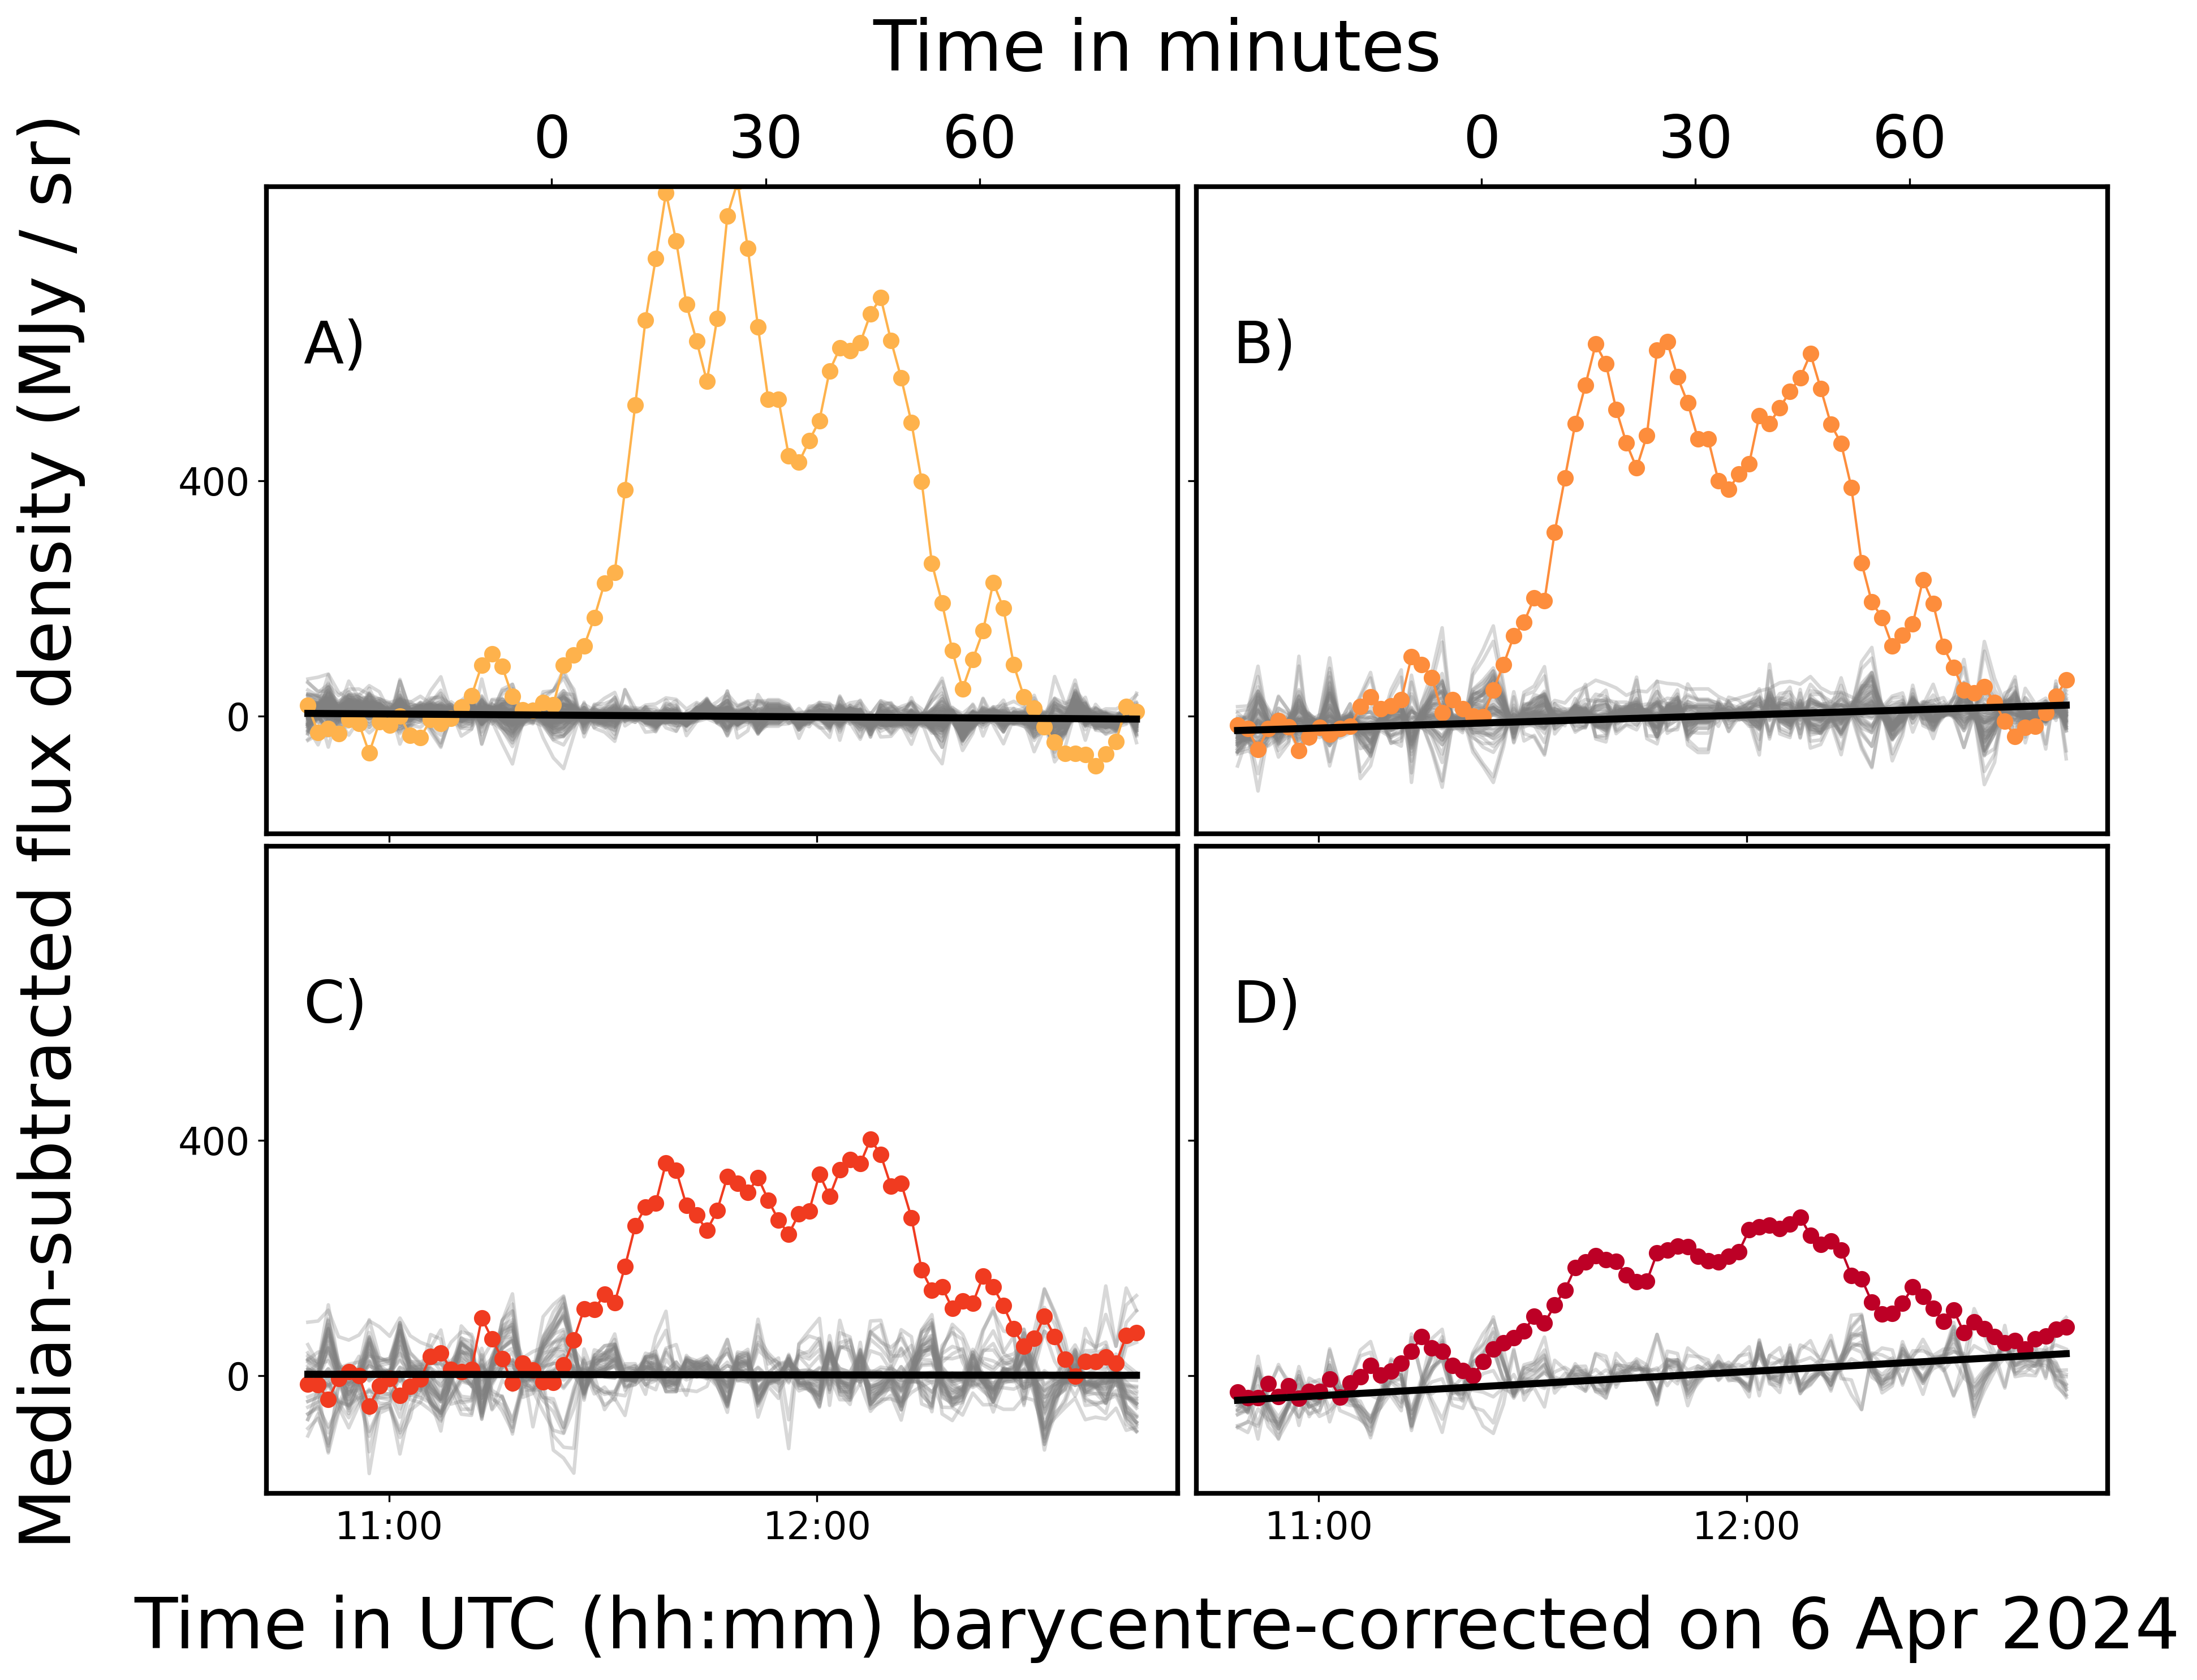

In [18]:
fig, ax = plt.subplots(2,2,figsize=(14,10), dpi=300,sharex=True, sharey=True, gridspec_kw={"hspace":0.02, "wspace":0.02})
#fig.add_subplot(111, frameon=False)

plt.rc('font', size=25)
#plt.rc('labels', size=25)

spine_thickness = 2
for spine in ax[0,0].spines.values():
    spine.set_linewidth(spine_thickness)
for spine in ax[0,1].spines.values():
    spine.set_linewidth(spine_thickness)
for spine in ax[1,0].spines.values():
    spine.set_linewidth(spine_thickness)
for spine in ax[1,1].spines.values():
    spine.set_linewidth(spine_thickness)
    
times0 = (np.load('times_barcorr/LC_CH1_APR6_TIMES_BARCORR.npy')-6)*24

    
    
[ax[0,0].plot(times0[3:], ref_ch1[j][3:]-np.nanmedian(ref_ch1[j]), color='grey',alpha=0.3) for j in range(ref_ch1.shape[0])]
ax[0,0].plot(times0[3:], sgra_ch1[3:]-np.nanmedian(sgra_ch1[3:30]), color=colors_channel[0],lw=1,marker='o')
ax[0,0].plot(times0[3:], trend_1[3:], color='k', lw=3)
ax[0,0].set_ylim(-200,900)
ax[0,0].text(10.8,600,'A)')

[ax[0,1].plot(times0[3:], ref_ch2[j][3:]-np.nanmedian(ref_ch2[j]), color='grey',alpha=0.3) for j in range(ref_ch2.shape[0])]
ax[0,1].plot(times0[3:], sgra_ch2[3:]-np.nanmedian(sgra_ch2[3:30]), color=colors_channel[1],lw=1,marker='o')
ax[0,1].plot(times0[3:], trend_2[3:], color='k', lw=3)
ax[0,1].set_ylim(-200,900)
ax[0,1].text(10.8,600,'B)')

[ax[1,0].plot(times0[3:], ref_ch3[j][3:]-np.nanmedian(ref_ch3[j]), color='grey',alpha=0.3) for j in range(ref_ch3.shape[0])]
ax[1,0].plot(times0[3:], sgra_ch3[3:]-np.nanmedian(sgra_ch3[3:30]), color=colors_channel[2],lw=1,marker='o')
ax[1,0].plot(times0[3:], trend_3[3:], color='k', lw=3)
ax[1,0].set_ylim(-200,900)
ax[1,0].text(10.8,600,'C)')

[ax[1,1].plot(times0[3:], ref_ch4[j][3:]-np.nanmedian(ref_ch4[j]), color='grey',alpha=0.3) for j in range(ref_ch4.shape[0])]
ax[1,1].plot(times0[3:], sgra_ch4[3:]-np.nanmedian(sgra_ch4[3:30]), color=colors_channel[3],lw=1,marker='o')
ax[1,1].plot(times0[3:], trend_4[3:], color='k', lw=3)
ax[1,1].set_ylim(-200,900)
ax[1,1].text(10.8,600,'D)')

#ax[1,0].set_xticks(np.arange(11, 12.76, 0.5), labels=['11:00','11:30','12:00','12:30'])
#ax[1,1].set_xticks(np.arange(11, 12.76, 0.5), labels=['11:00','11:30','12:00','12:30'])

ax[1,0].set_xticks([11,12], labels=['11:00','12:00'])
ax[1,1].set_xticks([11,12], labels=['11:00','12:00'])

#ax[0,1].axvline([11.5])
ax[0,0].set_yticks([0,400], labels=[0,400])
ax[0,1].set_yticks([0,400], labels=[0,400])

axa = ax[0,0].secondary_xaxis('top')
axa.set_xticks(np.arange(11.38, 12.76, 0.5), labels=['0','30','60'])
axb = ax[0,1].secondary_xaxis('top')
axb.set_xticks(np.arange(11.38, 12.76, 0.5), labels=['0','30','60'])

fig.supxlabel('Time in UTC (hh:mm) barycentre-corrected on 6 Apr 2024')
#axa.set_xlabel('Minutes since start of flare', verticalalignment='top')
fig.supylabel('Median-subtracted flux density (MJy / sr)')
fig.suptitle('Time in minutes')
#fig.suptitle('After Median subtraction, No Linear Trend correction')
plt.savefig('median-sub-lc.pdf')

/home/tamojeet/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


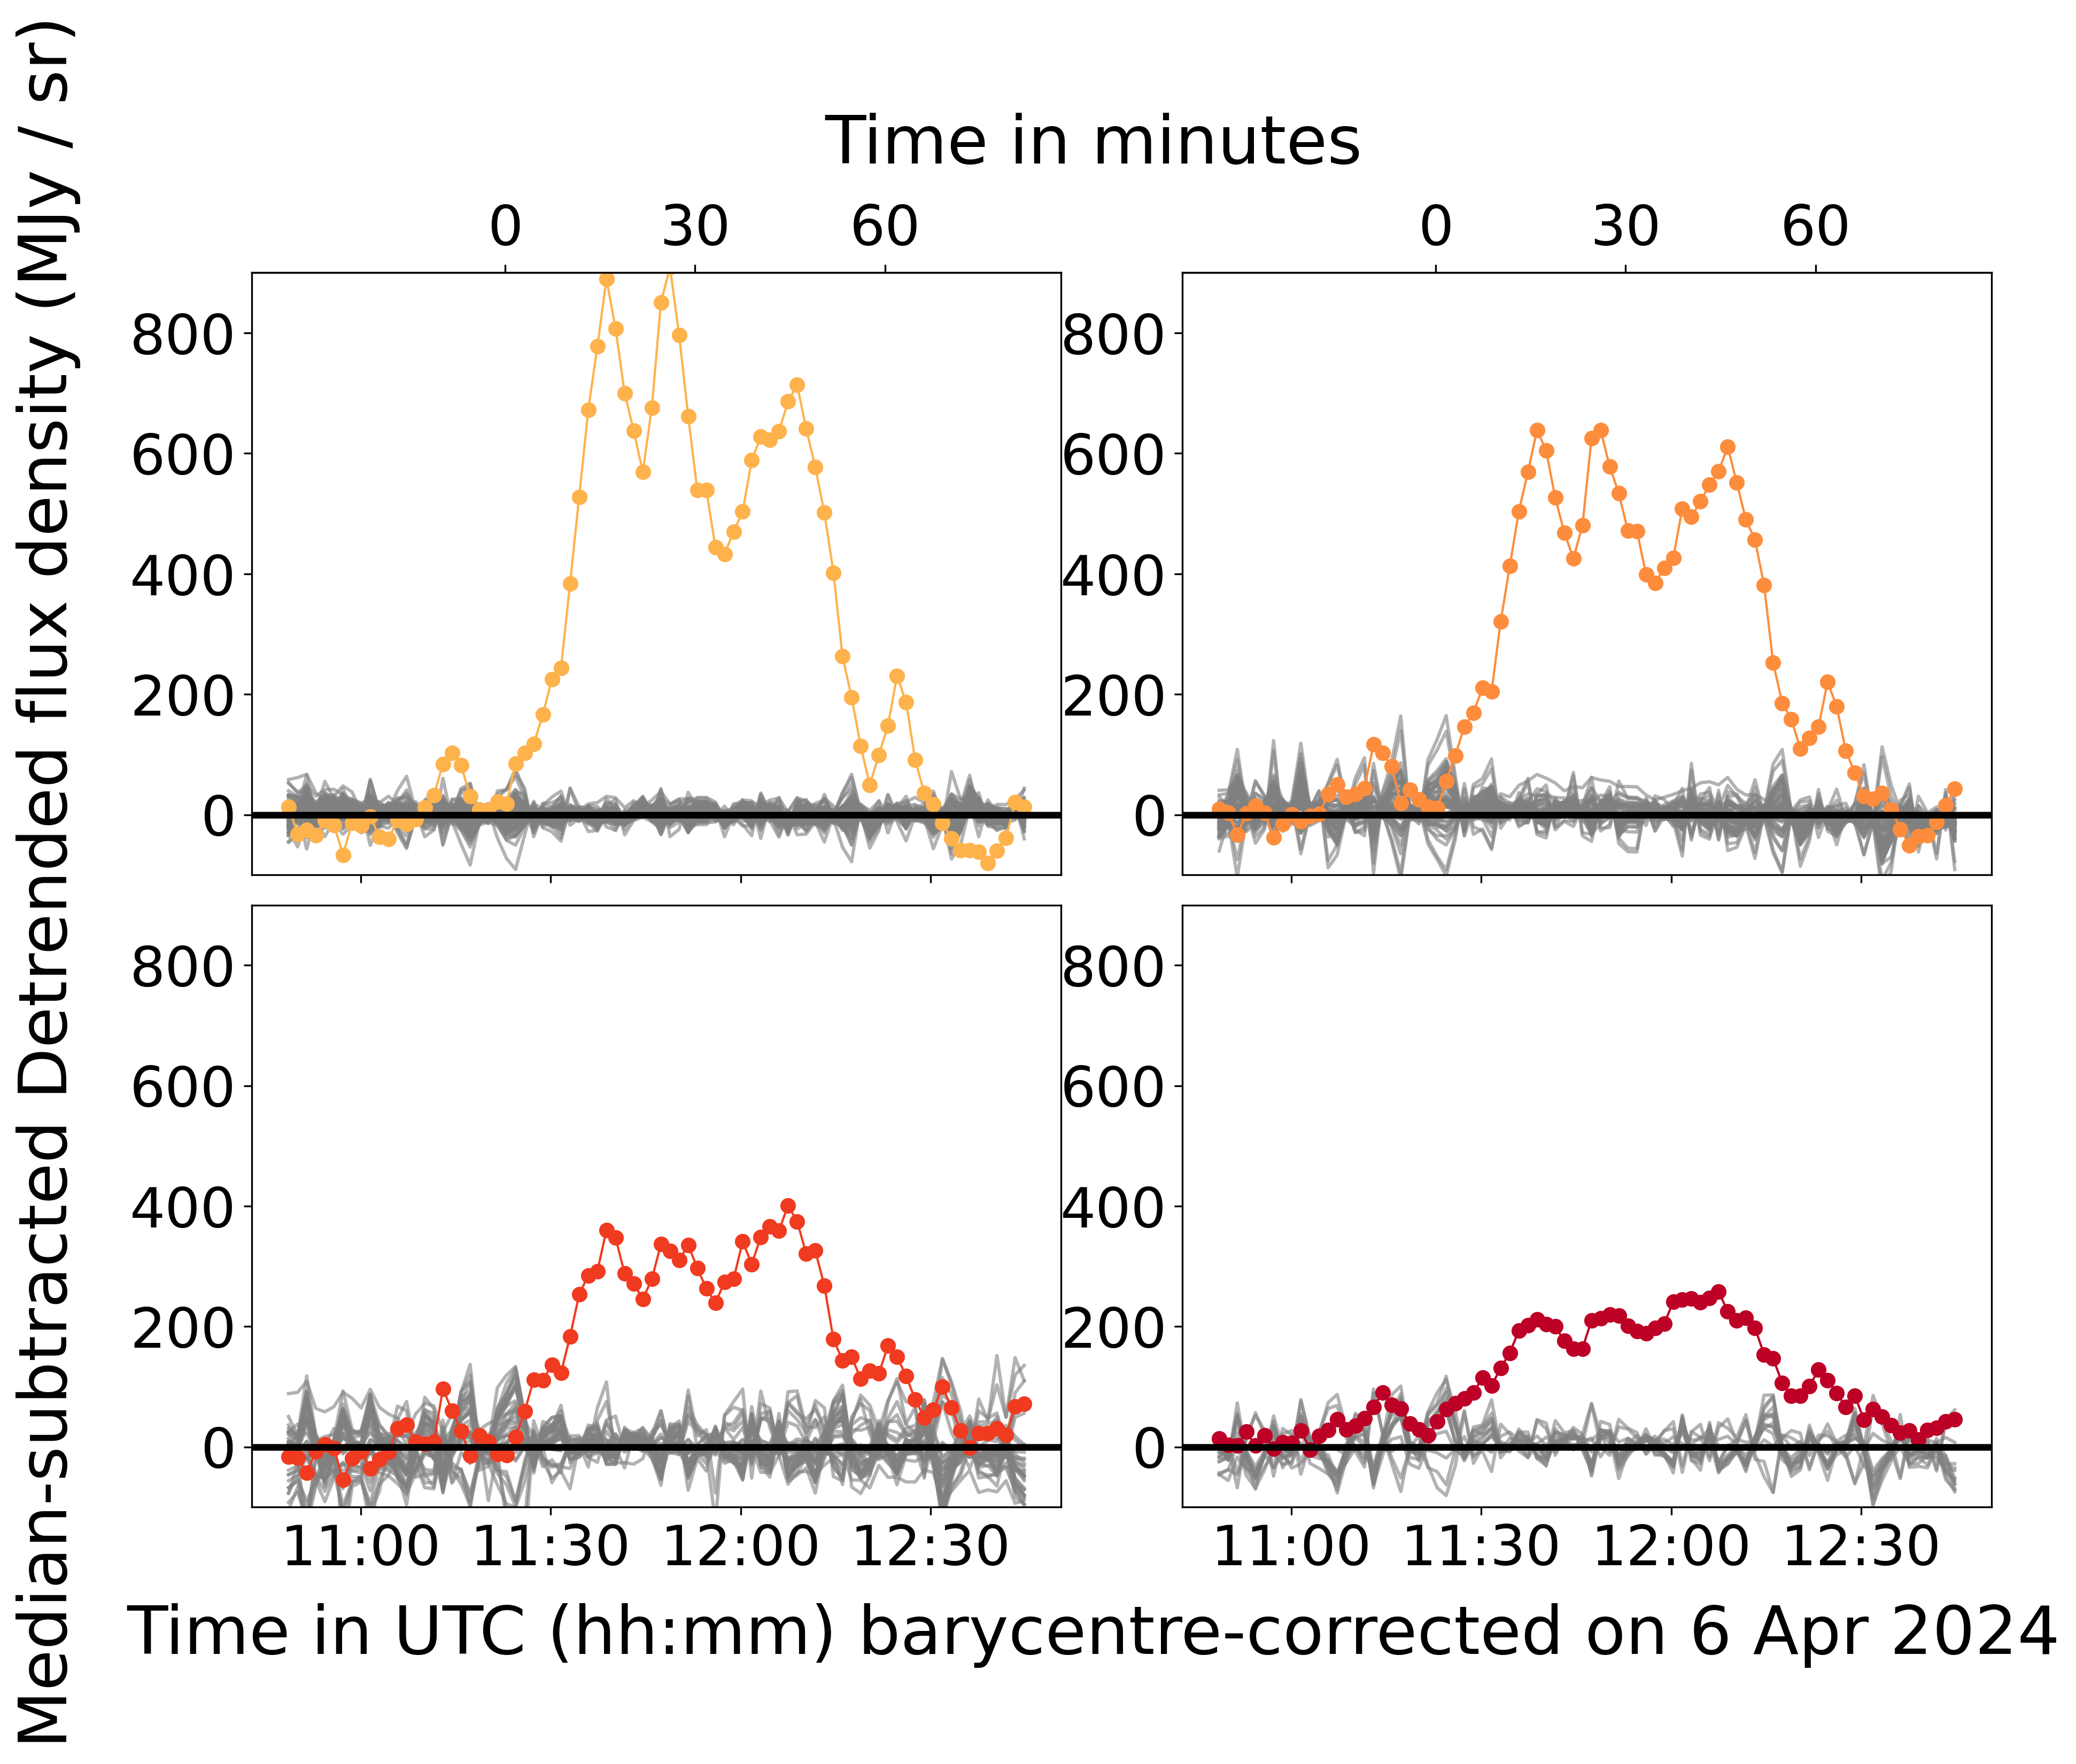

In [19]:
fig, ax = plt.subplots(2,2,figsize=(14,10), dpi=300,sharex=True, gridspec_kw={"hspace":0.05, "wspace":0.15})
#fig.add_subplot(111, frameon=False)

[ax[0,0].plot(times0[3:], ref_ch1[j][3:]-np.nanmedian(ref_ch1[j])-trend_1[3:], color='grey',alpha=0.6) for j in range(ref_ch1.shape[0])]
ax[0,0].plot(times0[3:], sgra_ch1[3:]-np.nanmedian(sgra_ch1[3:30])-trend_1[3:], color=colors_channel[0],lw=1,marker='o')
ax[0,0].axhline([0], lw=3, color='k')
ax[0,0].set_ylim(-100,900)

[ax[0,1].plot(times0[3:], ref_ch2[j][3:]-np.nanmedian(ref_ch2[j])-trend_2[3:], color='grey',alpha=0.6) for j in range(ref_ch2.shape[0])]
ax[0,1].plot(times0[3:], sgra_ch2[3:]-np.nanmedian(sgra_ch2[3:30])-trend_2[3:], color=colors_channel[1],lw=1,marker='o')
ax[0,1].axhline([0], lw=3, color='k')
ax[0,1].set_ylim(-100,900)

[ax[1,0].plot(times0[3:], ref_ch3[j][3:]-np.nanmedian(ref_ch3[j])-trend_3[3:], color='grey',alpha=0.6) for j in range(ref_ch3.shape[0])]
ax[1,0].plot(times0[3:], sgra_ch3[3:]-np.nanmedian(sgra_ch3[3:30])-trend_3[3:], color=colors_channel[2],lw=1,marker='o')
ax[1,0].axhline([0], lw=3, color='k')
ax[1,0].set_ylim(-100,900)

[ax[1,1].plot(times0[3:], ref_ch4[j][3:]-np.nanmedian(ref_ch4[j])-trend_4[3:], color='grey',alpha=0.6) for j in range(ref_ch4.shape[0])]
ax[1,1].plot(times0[3:], sgra_ch4[3:]-np.nanmedian(sgra_ch4[3:30])-trend_4[3:], color=colors_channel[3],lw=1,marker='o')
ax[1,1].axhline([0], lw=3, color='k')
ax[1,1].set_ylim(-100,900)

ax[1,0].set_xticks(np.arange(11, 12.76, 0.5), labels=['11:00','11:30','12:00','12:30'])
ax[1,1].set_xticks(np.arange(11, 12.76, 0.5), labels=['11:00','11:30','12:00','12:30'])

axa = ax[0,0].secondary_xaxis('top')
axa.set_xticks(np.arange(11.38, 12.76, 0.5), labels=['0','30','60'])
axb = ax[0,1].secondary_xaxis('top')
axb.set_xticks(np.arange(11.38, 12.76, 0.5), labels=['0','30','60'])

fig.suptitle('Time in minutes')
fig.supxlabel('Time in UTC (hh:mm) barycentre-corrected on 6 Apr 2024')
fig.supylabel('Median-subtracted Detrended flux density (MJy / sr)')
#fig.suptitle('After Median subtraction and Linear Trend correction')
plt.savefig('detrended-lc.pdf')

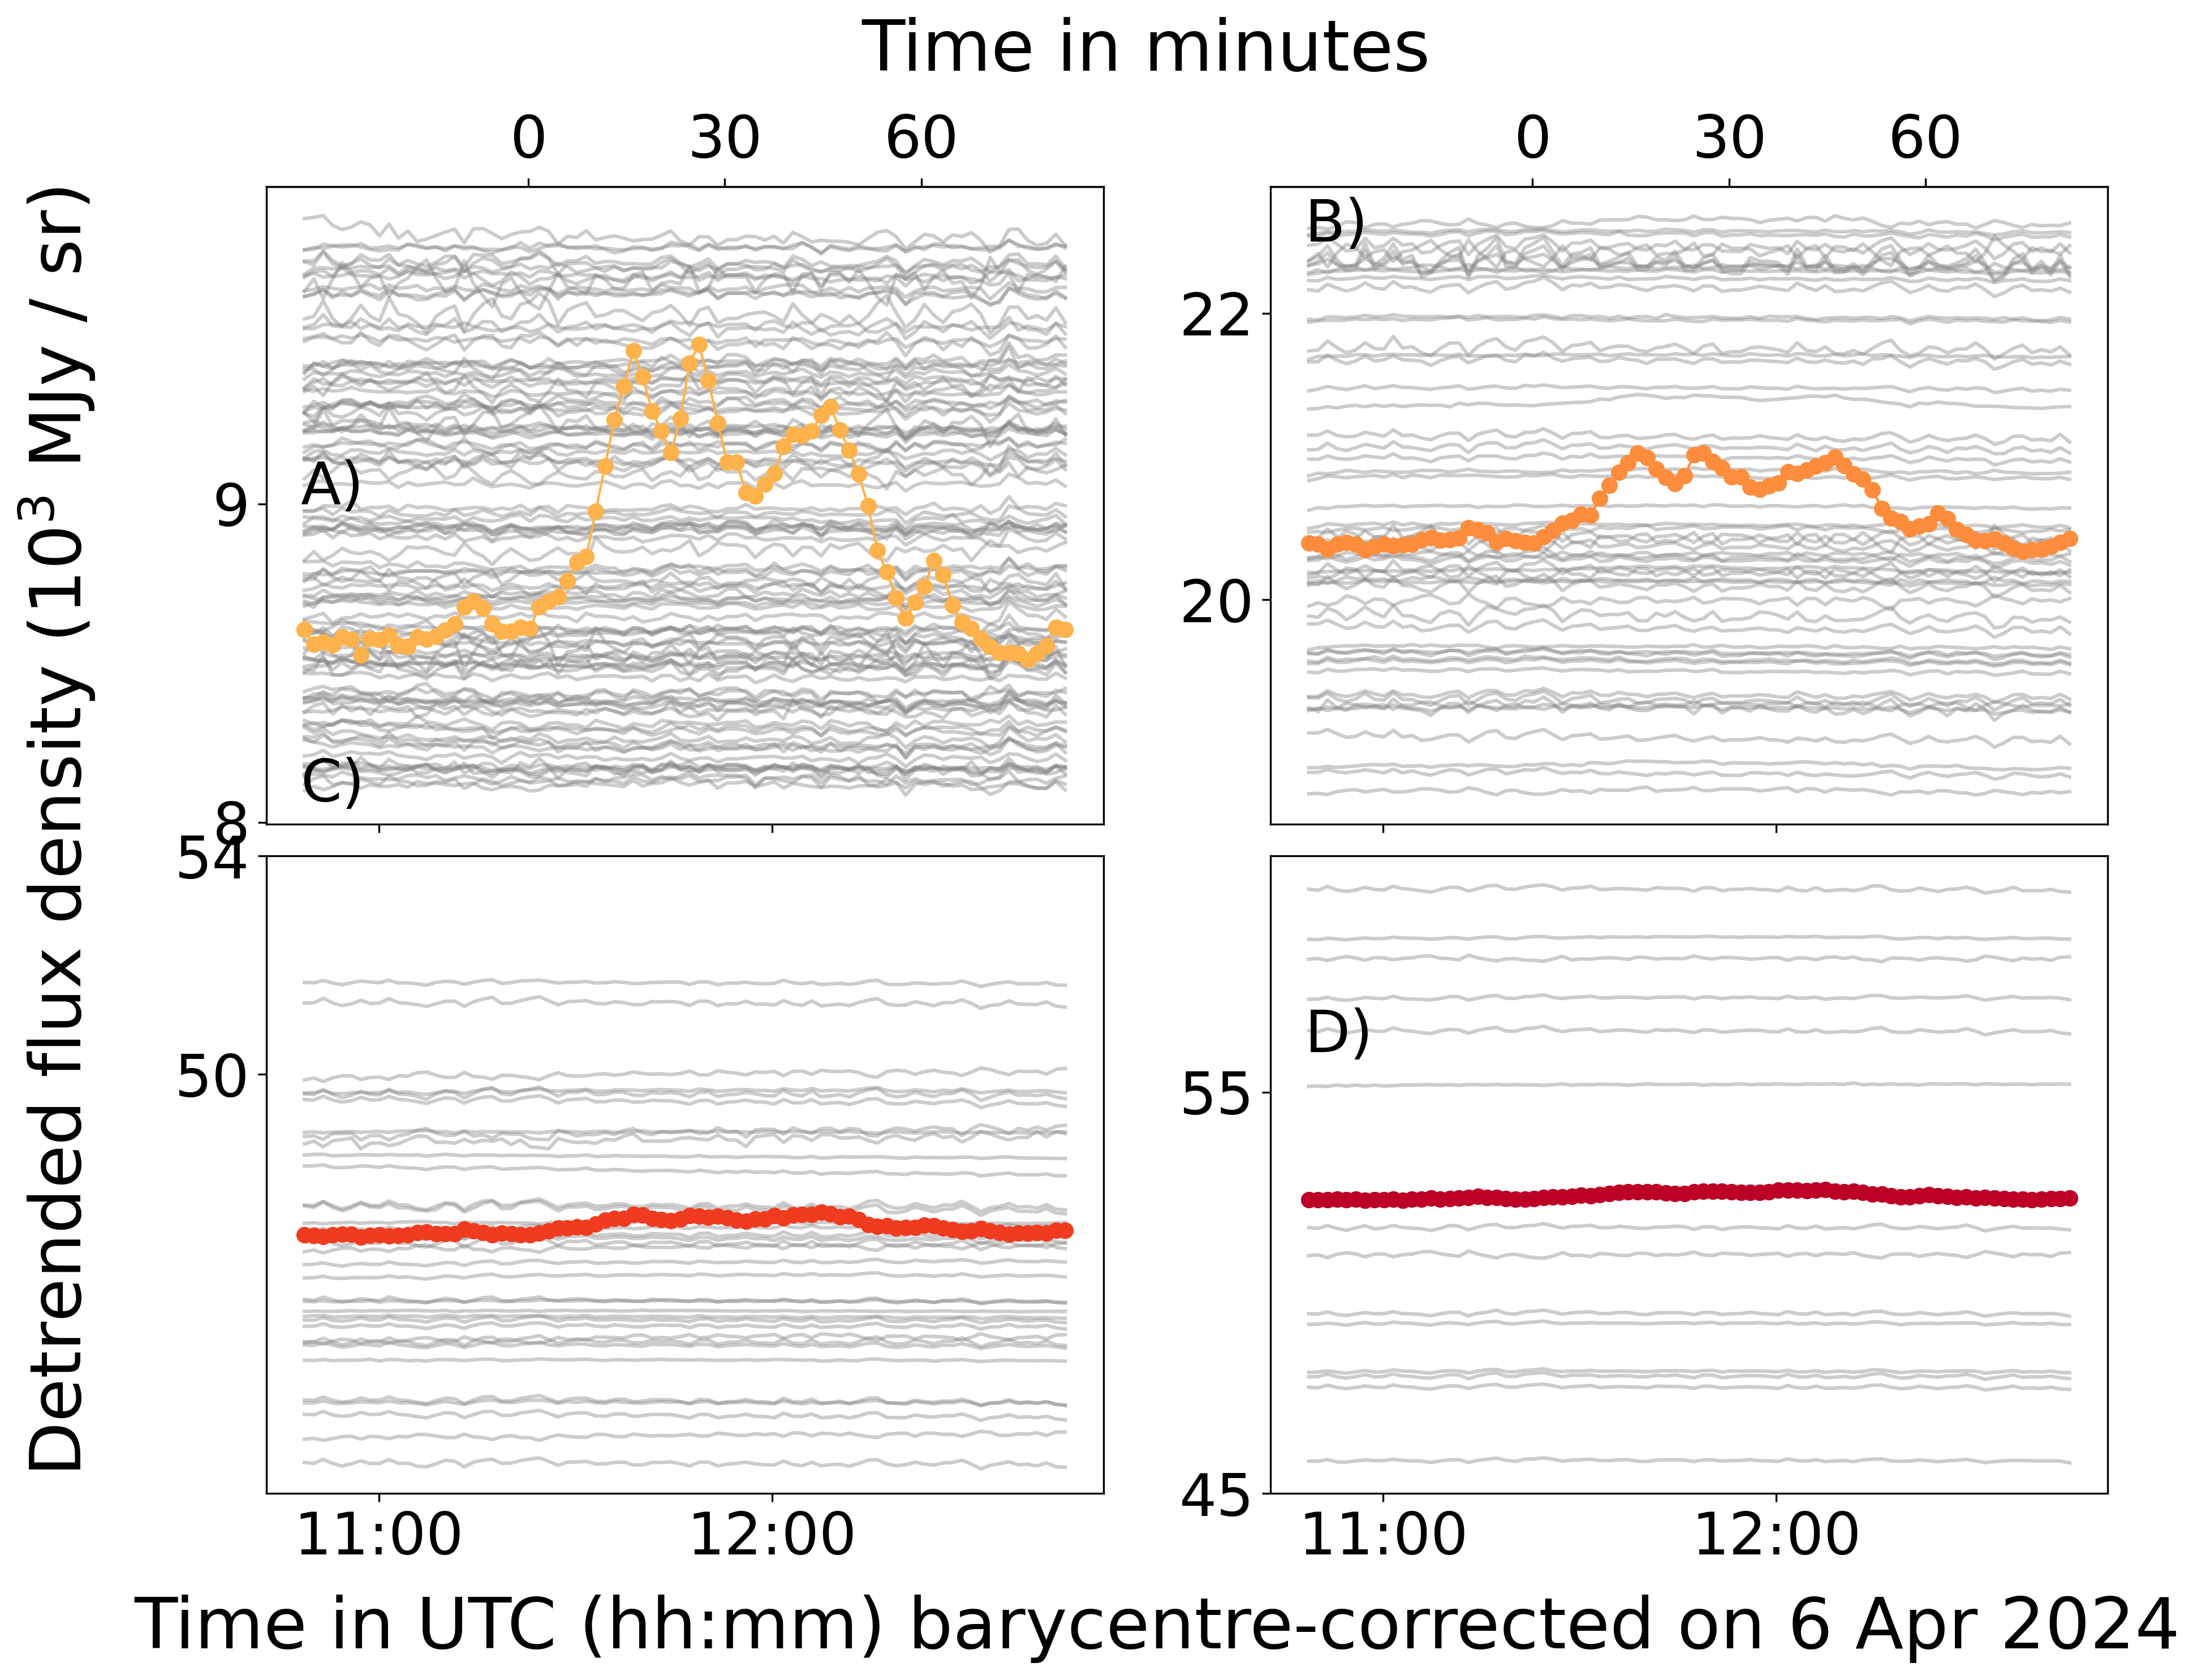

In [20]:
fig, ax = plt.subplots(2,2,figsize=(14,10), dpi=300,sharex=True, gridspec_kw={"hspace":0.05, "wspace":0.2})
#fig.add_subplot(111, frameon=False)

[ax[0,0].plot(times0[3:], ref_ch1[j][3:]-trend_1[3:], color='grey',alpha=0.4) for j in range(ref_ch1.shape[0])]
ax[0,0].plot(times0[3:], sgra_ch1[3:]-trend_1[3:], color=colors_channel[0],lw=1,marker='o')
#ax[0,0].axhline([0])
#ax[0,0].set_ylim(-100,750)
ax[0,0].text(10.8,9000,'A)')

[ax[0,1].plot(times0[3:], ref_ch2[j][3:]-trend_2[3:], color='grey',alpha=0.4) for j in range(ref_ch2.shape[0])]
ax[0,1].plot(times0[3:], sgra_ch2[3:]-trend_2[3:], color=colors_channel[1],lw=1,marker='o')
#ax[0,1].axhline([0])
#ax[0,1].set_ylim(-100,750)
ax[0,1].text(10.8,22500,'B)')

[ax[1,0].plot(times0[3:], ref_ch3[j][3:]-trend_3[3:], color='grey',alpha=0.4) for j in range(ref_ch3.shape[0])]
ax[1,0].plot(times0[3:], sgra_ch3[3:]-trend_3[3:], color=colors_channel[2],lw=1,marker='o')
#ax[1,0].axhline([0])
#ax[1,0].set_ylim(-100,750)
ax[1,0].text(10.8,55000,'C)')

[ax[1,1].plot(times0[3:], ref_ch4[j][3:]-trend_4[3:], color='grey',alpha=0.4) for j in range(ref_ch4.shape[0])]
ax[1,1].plot(times0[3:], sgra_ch4[3:]-trend_4[3:], color=colors_channel[3],lw=1,marker='o')
#ax[1,1].axhline([0])
#ax[1,1].set_ylim(-100,750)
ax[1,1].text(10.8,56000,'D)')


ax[1,0].set_xticks(np.arange(11, 12.76, 1), labels=['11:00','12:00'])
ax[1,1].set_xticks(np.arange(11, 12.76, 1), labels=['11:00','12:00'])


ax[0,0].set_yticks([8000,9000], labels=[8,9])
ax[0,1].set_yticks([20000,22000], labels=[20,22])
ax[1,0].set_yticks([50000,54000], labels=[50,54])
ax[1,1].set_yticks([45000,55000], labels=[45,55])

axa = ax[0,0].secondary_xaxis('top')
axa.set_xticks(np.arange(11.38, 12.76, 0.5), labels=['0','30','60'])
axb = ax[0,1].secondary_xaxis('top')
axb.set_xticks(np.arange(11.38, 12.76, 0.5), labels=['0','30','60'])


fig.supxlabel('Time in UTC (hh:mm) barycentre-corrected on 6 Apr 2024')
fig.supylabel('Detrended flux density ($10^3$ MJy / sr)')
fig.suptitle('Time in minutes ')
#fig.suptitle('After Median subtraction and Linear Trend correction')
plt.savefig('abs-detrended-lc.pdf')